## Libarary 불러오기

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm 
import glob 

import matplotlib.pyplot as plt
import numpy as np 

## Albumentation (get_transform 정의)

In [2]:
from albumentations import *
from albumentations.pytorch import ToTensorV2

def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

    return transformations

## Model 정의

In [3]:
import timm 

In [4]:
device =  torch.device("cuda")
model = timm.create_model('resnet50', pretrained=True) # resnet50 

In [5]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet50'}

## Custom Dataset class (미션 코드)

강의 코드랑 다른점은 `__getitem()__` 부분 

```python
return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}
```
dictionary, label 별로 return 

In [6]:
from enum import Enum # 서로 관련이 있는 여러개의 상수의 집합 정의 
# .name 이랑 .value 통해서 이름이랑 값 호출 가능 

class MaskLabels(int, Enum): 
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [7]:
class MaskBaseDataset(Dataset):
    

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, mean, std, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.img_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return {'image': image_transform, 'mask': mask_label, 'gender': gender_label, 'age': age_label}

    def __len__(self):
        return len(self.image_paths)

In [8]:
# 미션 코드로 얻은 평균, 표준편차 값 
mean = [0.56019265, 0.52410305, 0.50145299]
std = [0.23308824, 0.24294489, 0.2456003]

In [9]:
# transform 할당 
transform = get_transforms(mean=mean, std=std, img_size=(224, 224))

In [10]:
# train 데이터 경로 설정 
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [11]:
# trainset 정의 
trainset = MaskBaseDataset(img_dir=img_dir, mean=mean, std=std, transform=transform)

In [12]:
# train, valid 분리용
from sklearn.model_selection import train_test_split

In [13]:
# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(trainset) * 0.2)
n_train = len(trainset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [14]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
BATCH_SIZE = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
train_steps = len(train_loader.dataset) // BATCH_SIZE
val_steps = len(val_loader.dataset) // BATCH_SIZE

In [15]:
# shape 확인 
data_dict = next(iter(train_loader))
print("image.shape: ", data_dict['image'].shape)
print("label.gender.shape: ", data_dict['gender'].shape)
print("label.mask.shape: ", data_dict['mask'].shape)
print("label.age.shape: ", data_dict['age'].shape)

image.shape:  torch.Size([64, 3, 224, 224])
label.gender.shape:  torch.Size([64])
label.mask.shape:  torch.Size([64])
label.age.shape:  torch.Size([64])


In [16]:
from collections import OrderedDict

## MultiTask 모델 만들기
위에서 다운받은 resnet 기반, forward에서 3가지의 pred label 반환 

In [17]:
class MultiTaskNet(nn.Module):
    def __init__(self, net):
        super(MultiTaskNet, self).__init__()
        self.net = net
        self.n_features = self.net.fc.in_features
        self.net.fc = nn.Identity()
        self.net.fc1 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 1))]))
        self.net.fc2 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        self.net.fc3 = nn.Sequential(OrderedDict([('linear', nn.Linear(self.n_features,self.n_features)),('relu1', nn.ReLU()),('final', nn.Linear(self.n_features, 3))]))
        
    def forward(self, x):
        gender_head = self.net.fc1(self.net(x))
        age_head = self.net.fc2(self.net(x))
        mask_head = self.net.fc3(self.net(x))
        return age_head, gender_head, mask_head

mask, age는 다중 분류, 성별은 이진분류 Loss 적용 

In [18]:
net = MultiTaskNet(model)
net.to(device=device)

mask_loss = nn.CrossEntropyLoss() # Includes Softmax
gender_loss = nn.BCELoss() # Don't include Softmax
age_loss = nn.CrossEntropyLoss()

lr = 1e-4
momentum = 0.09 # Meaning that we will go 9% with the previous direction
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [19]:
n_epochs = 50

logger = {"train_loss": list(),
          "validation_loss": list(),
          "train_gender_loss": list(),
          "train_mask_loss": list(),
          "train_age_loss": list(),
          "validation_gender_loss": list(),
          "validation_mask_loss": list(),
          "validation_age_loss": list(),
          }

## Train Code 

In [20]:
sig = nn.Sigmoid()

for epoch in tqdm(range(n_epochs)):
    model.train()

    total_training_loss = 0
    total_validation_loss = 0
    training_gender_loss = 0
    training_mask_loss = 0
    training_age_loss = 0
    validation_gender_loss = 0
    validation_mask_loss = 0
    validation_age_loss = 0

    for i, data in tqdm(enumerate(train_loader)):
        
        inputs = data["image"].to(device=device)

        age_label = data["age"].to(device=device)
        gender_label = data["gender"].to(device=device)
        mask_label = data["mask"].to(device=device)

        optimizer.zero_grad()
        age_output, gender_output, mask_output = net(inputs)
        #print(type(age_label.unsqueeze(1)))
        #print(age_output.shape, age_label.shape)

        loss_1 = age_loss(age_output, age_label)
        loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
        loss_3 = mask_loss(mask_output, mask_label)
        
        loss = loss_1 + loss_2 + loss_3

        loss.backward()
        optimizer.step()
        total_training_loss += loss

        training_age_loss += loss_1.item()
        training_gender_loss += loss_2.item()
        training_mask_loss += loss_3.item()
        
        

    print('EPOCH ', epoch+1)
    print("Training Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    with torch.no_grad():
        model.eval()

        for i, data in tqdm(enumerate(val_loader)):
            inputs = data["image"].to(device=device)

            age_label = data["age"].to(device=device)
            gender_label = data["gender"].to(device=device)
            mask_label =  data["mask"].to(device=device)
            age_output, gender_output, mask_output = net(inputs)
            # print(age_output, age_label.unsqueeze(1).float())
            loss_1 = age_loss(age_output, age_label)
            loss_2 = gender_loss(sig(gender_output), gender_label.unsqueeze(1).float())
            loss_3 = mask_loss(mask_output, mask_label)

            loss = loss_1 + loss_2 + loss_3
            total_validation_loss += loss
            
            validation_age_loss += loss_1.item()
            validation_gender_loss += loss_2.item()
            validation_mask_loss += loss_3.item()
            
            
        print("Validation Losses: Mask: {}, Gender: {}, Age: {}".format(loss_3, loss_2, loss_1))

    avgTrainLoss = total_training_loss / train_steps
    avgValLoss = total_validation_loss / val_steps
    
    print('Average Losses — Training: {} | Validation {}'.format(avgTrainLoss, avgValLoss))
    print() 
    avgTrainGenderLoss = training_gender_loss/len(train_loader.dataset)
    avgTrainMaskLoss = training_mask_loss/len(train_loader.dataset)
    avgTrainAgeLoss = training_age_loss/len(train_loader.dataset)

    avgValGenderLoss = validation_gender_loss/len(val_loader.dataset)
    avgValMaskLoss = validation_mask_loss/len(val_loader.dataset)
    avgValAgeLoss = validation_age_loss/len(val_loader.dataset)

    logger["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    logger["train_gender_loss"].append(avgTrainGenderLoss)
    logger["train_mask_loss"].append(avgTrainMaskLoss)
    logger["train_age_loss"].append(avgTrainAgeLoss)
    
    logger["validation_loss"].append(avgValLoss.cpu().detach().numpy())
    logger["validation_gender_loss"].append(avgValGenderLoss)
    logger["validation_mask_loss"].append(avgValMaskLoss)
    logger["validation_age_loss"].append(avgValAgeLoss)

237it [03:07,  1.27it/s]0:00<?, ?it/s]


EPOCH  1
Training Losses: Mask: 1.0814462900161743, Gender: 0.6957118511199951, Age: 1.0890988111495972


60it [00:23,  2.51it/s]
  2%|▏         | 1/50 [03:31<2:52:25, 211.14s/it]

Validation Losses: Mask: 1.0506768226623535, Gender: 0.7002612352371216, Age: 1.084482192993164
Average Losses — Training: 2.886150598526001 | Validation 2.8873302936553955



237it [03:05,  1.27it/s]


EPOCH  2
Training Losses: Mask: 0.9987831115722656, Gender: 0.6932193636894226, Age: 1.073203682899475


60it [00:22,  2.67it/s]
  4%|▍         | 2/50 [06:59<2:48:17, 210.36s/it]

Validation Losses: Mask: 1.002369999885559, Gender: 0.6907534003257751, Age: 1.058441400527954
Average Losses — Training: 2.8252644538879395 | Validation 2.8268892765045166



237it [03:04,  1.28it/s]


EPOCH  3
Training Losses: Mask: 0.9936816096305847, Gender: 0.6958543062210083, Age: 1.0331153869628906


60it [00:22,  2.64it/s]
  6%|▌         | 3/50 [10:27<2:44:11, 209.61s/it]

Validation Losses: Mask: 0.955775260925293, Gender: 0.6810148358345032, Age: 1.0474853515625
Average Losses — Training: 2.77174973487854 | Validation 2.7734568119049072



237it [03:04,  1.28it/s]


EPOCH  4
Training Losses: Mask: 0.9595295786857605, Gender: 0.6945837736129761, Age: 1.0592010021209717


60it [00:22,  2.63it/s]
  8%|▊         | 4/50 [13:55<2:40:13, 208.99s/it]

Validation Losses: Mask: 0.9172192811965942, Gender: 0.6747715473175049, Age: 1.0356993675231934
Average Losses — Training: 2.723845958709717 | Validation 2.742464065551758



237it [03:05,  1.28it/s]


EPOCH  5
Training Losses: Mask: 0.9059581160545349, Gender: 0.6848992705345154, Age: 1.033925175666809


60it [00:22,  2.65it/s]
 10%|█         | 5/50 [17:23<2:36:31, 208.70s/it]

Validation Losses: Mask: 0.8574856519699097, Gender: 0.6650964617729187, Age: 1.0168864727020264
Average Losses — Training: 2.680536985397339 | Validation 2.6843082904815674



237it [03:05,  1.28it/s]


EPOCH  6
Training Losses: Mask: 0.8413294553756714, Gender: 0.6821883916854858, Age: 1.0315096378326416


60it [00:22,  2.64it/s]
 12%|█▏        | 6/50 [20:51<2:32:57, 208.57s/it]

Validation Losses: Mask: 0.8137642741203308, Gender: 0.6564885377883911, Age: 0.9998494386672974
Average Losses — Training: 2.6427531242370605 | Validation 2.6469390392303467



237it [03:04,  1.28it/s]


EPOCH  7
Training Losses: Mask: 0.8795864582061768, Gender: 0.6966513395309448, Age: 1.0363808870315552


60it [00:22,  2.63it/s]
 14%|█▍        | 7/50 [24:18<2:29:14, 208.23s/it]

Validation Losses: Mask: 0.7954123616218567, Gender: 0.6540221571922302, Age: 0.9867725968360901
Average Losses — Training: 2.60862398147583 | Validation 2.6107773780822754



237it [03:05,  1.28it/s]


EPOCH  8
Training Losses: Mask: 0.7920135259628296, Gender: 0.6715044975280762, Age: 0.9603136777877808


60it [00:22,  2.63it/s]
 16%|█▌        | 8/50 [27:47<2:25:50, 208.34s/it]

Validation Losses: Mask: 0.7548805475234985, Gender: 0.6422828435897827, Age: 0.975480318069458
Average Losses — Training: 2.578350305557251 | Validation 2.5782196521759033



237it [03:05,  1.28it/s]


EPOCH  9
Training Losses: Mask: 0.9203031063079834, Gender: 0.6741296052932739, Age: 0.9873455166816711


60it [00:22,  2.62it/s]
 18%|█▊        | 9/50 [31:15<2:22:19, 208.28s/it]

Validation Losses: Mask: 0.7154421806335449, Gender: 0.6356608271598816, Age: 0.9679371118545532
Average Losses — Training: 2.5518434047698975 | Validation 2.5526952743530273



237it [03:05,  1.28it/s]


EPOCH  10
Training Losses: Mask: 0.9796398878097534, Gender: 0.6884486675262451, Age: 1.0689709186553955


60it [00:22,  2.64it/s]
 20%|██        | 10/50 [34:43<2:18:48, 208.21s/it]

Validation Losses: Mask: 0.6890330910682678, Gender: 0.626949667930603, Age: 0.9492905735969543
Average Losses — Training: 2.528568744659424 | Validation 2.5238280296325684



237it [03:04,  1.28it/s]


EPOCH  11
Training Losses: Mask: 0.7309460639953613, Gender: 0.6688402891159058, Age: 0.9977291226387024


60it [00:22,  2.67it/s]
 22%|██▏       | 11/50 [38:10<2:15:09, 207.93s/it]

Validation Losses: Mask: 0.6650530099868774, Gender: 0.6246356964111328, Age: 0.946750283241272
Average Losses — Training: 2.5061962604522705 | Validation 2.507990837097168



237it [03:05,  1.28it/s]


EPOCH  12
Training Losses: Mask: 0.8504210114479065, Gender: 0.6939007639884949, Age: 0.9617123603820801


60it [00:22,  2.64it/s]
 24%|██▍       | 12/50 [41:38<2:11:43, 207.98s/it]

Validation Losses: Mask: 0.6762092709541321, Gender: 0.627496063709259, Age: 0.9451118111610413
Average Losses — Training: 2.4874112606048584 | Validation 2.4916253089904785



237it [03:05,  1.28it/s]


EPOCH  13
Training Losses: Mask: 0.8455033898353577, Gender: 0.655327320098877, Age: 0.952850878238678


60it [00:22,  2.67it/s]
 26%|██▌       | 13/50 [45:06<2:08:15, 207.98s/it]

Validation Losses: Mask: 0.5919862985610962, Gender: 0.6070160269737244, Age: 0.917607307434082
Average Losses — Training: 2.4697976112365723 | Validation 2.459709405899048



237it [03:05,  1.28it/s]


EPOCH  14
Training Losses: Mask: 0.8559211492538452, Gender: 0.656797468662262, Age: 0.923708975315094


60it [00:22,  2.63it/s]
 28%|██▊       | 14/50 [48:35<2:04:55, 208.21s/it]

Validation Losses: Mask: 0.6852151155471802, Gender: 0.6256805062294006, Age: 0.9474299550056458
Average Losses — Training: 2.456023931503296 | Validation 2.529012441635132



237it [03:05,  1.28it/s]


EPOCH  15
Training Losses: Mask: 0.9154938459396362, Gender: 0.6451462507247925, Age: 0.8982158303260803


60it [00:22,  2.68it/s]
 30%|███       | 15/50 [52:03<2:01:23, 208.09s/it]

Validation Losses: Mask: 0.5702601671218872, Gender: 0.6006382703781128, Age: 0.9079747200012207
Average Losses — Training: 2.4431426525115967 | Validation 2.4327430725097656



237it [03:06,  1.27it/s]


EPOCH  16
Training Losses: Mask: 0.7135815620422363, Gender: 0.6603624224662781, Age: 0.9229931235313416


60it [00:23,  2.59it/s]
 32%|███▏      | 16/50 [55:33<1:58:14, 208.67s/it]

Validation Losses: Mask: 0.5592606663703918, Gender: 0.5989230275154114, Age: 0.9014397859573364
Average Losses — Training: 2.430525541305542 | Validation 2.4190175533294678



237it [03:05,  1.28it/s]


EPOCH  17
Training Losses: Mask: 1.0393716096878052, Gender: 0.6786548495292664, Age: 0.9875813722610474


60it [00:22,  2.63it/s]
 34%|███▍      | 17/50 [59:02<1:54:45, 208.64s/it]

Validation Losses: Mask: 0.538139820098877, Gender: 0.593799352645874, Age: 0.8889341950416565
Average Losses — Training: 2.4222159385681152 | Validation 2.410170078277588



237it [03:04,  1.29it/s]


EPOCH  18
Training Losses: Mask: 0.7942891716957092, Gender: 0.6297086477279663, Age: 0.962903618812561


60it [00:22,  2.71it/s]
 36%|███▌      | 18/50 [1:02:28<1:50:55, 207.98s/it]

Validation Losses: Mask: 0.5238205194473267, Gender: 0.5912365913391113, Age: 0.8911299705505371
Average Losses — Training: 2.411421298980713 | Validation 2.406980514526367



237it [03:02,  1.30it/s]


EPOCH  19
Training Losses: Mask: 0.835741400718689, Gender: 0.7059593200683594, Age: 0.921715497970581


60it [00:22,  2.64it/s]
 38%|███▊      | 19/50 [1:05:54<1:47:05, 207.26s/it]

Validation Losses: Mask: 0.48890411853790283, Gender: 0.5791035890579224, Age: 0.873859167098999
Average Losses — Training: 2.402845859527588 | Validation 2.384166955947876



237it [03:04,  1.28it/s]


EPOCH  20
Training Losses: Mask: 0.6716611385345459, Gender: 0.7122031450271606, Age: 0.9105889797210693


60it [00:22,  2.64it/s]
 40%|████      | 20/50 [1:09:21<1:43:42, 207.41s/it]

Validation Losses: Mask: 0.5140388011932373, Gender: 0.583082914352417, Age: 0.8802833557128906
Average Losses — Training: 2.394733428955078 | Validation 2.3874003887176514



237it [03:04,  1.28it/s]


EPOCH  21
Training Losses: Mask: 0.8402178883552551, Gender: 0.6873791217803955, Age: 0.8462274670600891


60it [00:22,  2.62it/s]
 42%|████▏     | 21/50 [1:12:49<1:40:19, 207.56s/it]

Validation Losses: Mask: 0.5057234168052673, Gender: 0.5807441473007202, Age: 0.8746854662895203
Average Losses — Training: 2.3881752490997314 | Validation 2.3719072341918945



237it [03:06,  1.27it/s]


EPOCH  22
Training Losses: Mask: 0.7583243250846863, Gender: 0.6085777282714844, Age: 0.9040260314941406


60it [00:22,  2.66it/s]
 44%|████▍     | 22/50 [1:16:19<1:37:06, 208.10s/it]

Validation Losses: Mask: 0.4686264991760254, Gender: 0.5685462355613708, Age: 0.8617002367973328
Average Losses — Training: 2.381338119506836 | Validation 2.3697454929351807



237it [03:03,  1.29it/s]


EPOCH  23
Training Losses: Mask: 0.7985943555831909, Gender: 0.6692049503326416, Age: 0.908146321773529


60it [00:23,  2.61it/s]
 46%|████▌     | 23/50 [1:19:45<1:33:28, 207.70s/it]

Validation Losses: Mask: 0.5742737650871277, Gender: 0.5939311981201172, Age: 0.8918923139572144
Average Losses — Training: 2.3766703605651855 | Validation 2.4240305423736572



237it [03:04,  1.28it/s]


EPOCH  24
Training Losses: Mask: 0.8334885239601135, Gender: 0.6236131191253662, Age: 0.825131893157959


60it [00:23,  2.58it/s]
 48%|████▊     | 24/50 [1:23:14<1:30:03, 207.83s/it]

Validation Losses: Mask: 0.47694653272628784, Gender: 0.5707210302352905, Age: 0.8590905666351318
Average Losses — Training: 2.371364116668701 | Validation 2.3615336418151855



237it [03:05,  1.28it/s]


EPOCH  25
Training Losses: Mask: 0.5641599893569946, Gender: 0.6319767832756042, Age: 0.9792112708091736


60it [00:23,  2.60it/s]
 50%|█████     | 25/50 [1:26:43<1:26:44, 208.18s/it]

Validation Losses: Mask: 0.4537825882434845, Gender: 0.5651065111160278, Age: 0.8529748916625977
Average Losses — Training: 2.365579605102539 | Validation 2.351010799407959



237it [03:04,  1.28it/s]


EPOCH  26
Training Losses: Mask: 0.7053449749946594, Gender: 0.7563350796699524, Age: 0.8393797874450684


60it [00:22,  2.65it/s]
 52%|█████▏    | 26/50 [1:30:10<1:23:10, 207.95s/it]

Validation Losses: Mask: 0.44431906938552856, Gender: 0.5575012564659119, Age: 0.8481936454772949
Average Losses — Training: 2.3609471321105957 | Validation 2.3479838371276855



237it [03:04,  1.29it/s]


EPOCH  27
Training Losses: Mask: 0.8139256238937378, Gender: 0.6348917484283447, Age: 1.0431073904037476


60it [00:22,  2.62it/s]
 54%|█████▍    | 27/50 [1:33:37<1:19:39, 207.80s/it]

Validation Losses: Mask: 0.43305882811546326, Gender: 0.5514923334121704, Age: 0.836877167224884
Average Losses — Training: 2.3574652671813965 | Validation 2.3373801708221436



237it [03:05,  1.27it/s]


EPOCH  28
Training Losses: Mask: 0.7005216479301453, Gender: 0.7299374341964722, Age: 0.8776335716247559


60it [00:22,  2.65it/s]
 56%|█████▌    | 28/50 [1:37:06<1:16:17, 208.08s/it]

Validation Losses: Mask: 0.43324434757232666, Gender: 0.5522904992103577, Age: 0.8326855301856995
Average Losses — Training: 2.353070020675659 | Validation 2.3291075229644775



237it [03:04,  1.28it/s]


EPOCH  29
Training Losses: Mask: 0.6573880910873413, Gender: 0.6733723878860474, Age: 0.8845828175544739


60it [00:23,  2.60it/s]
 58%|█████▊    | 29/50 [1:40:34<1:12:49, 208.09s/it]

Validation Losses: Mask: 0.4452942907810211, Gender: 0.5530465841293335, Age: 0.8322859406471252
Average Losses — Training: 2.348809003829956 | Validation 2.328230381011963



237it [03:05,  1.28it/s]


EPOCH  30
Training Losses: Mask: 0.8654903173446655, Gender: 0.7506468296051025, Age: 0.9071874022483826


60it [00:23,  2.55it/s]
 60%|██████    | 30/50 [1:44:03<1:09:27, 208.37s/it]

Validation Losses: Mask: 0.4359717071056366, Gender: 0.5497173070907593, Age: 0.8280510306358337
Average Losses — Training: 2.345846176147461 | Validation 2.3327856063842773



237it [03:04,  1.28it/s]


EPOCH  31
Training Losses: Mask: 0.7016223669052124, Gender: 0.6032354831695557, Age: 1.0010855197906494


60it [00:23,  2.59it/s]
 62%|██████▏   | 31/50 [1:47:32<1:05:58, 208.36s/it]

Validation Losses: Mask: 0.43904513120651245, Gender: 0.5507844686508179, Age: 0.8292624354362488
Average Losses — Training: 2.3416545391082764 | Validation 2.3195621967315674



237it [03:06,  1.27it/s]


EPOCH  32
Training Losses: Mask: 0.7275838851928711, Gender: 0.7066283226013184, Age: 1.166388750076294


60it [00:23,  2.61it/s]
 64%|██████▍   | 32/50 [1:51:01<1:02:35, 208.64s/it]

Validation Losses: Mask: 0.3815290629863739, Gender: 0.5304450988769531, Age: 0.8136125206947327
Average Losses — Training: 2.3386571407318115 | Validation 2.313699245452881



237it [03:05,  1.28it/s]


EPOCH  33
Training Losses: Mask: 0.4675760269165039, Gender: 0.6641029715538025, Age: 0.8692193031311035


60it [00:22,  2.66it/s]
 66%|██████▌   | 33/50 [1:54:29<59:04, 208.48s/it]  

Validation Losses: Mask: 0.42690348625183105, Gender: 0.542884349822998, Age: 0.8256813883781433
Average Losses — Training: 2.334665536880493 | Validation 2.31618070602417



237it [03:04,  1.28it/s]


EPOCH  34
Training Losses: Mask: 0.5679254531860352, Gender: 0.6759011745452881, Age: 0.9331670999526978


60it [00:22,  2.63it/s]
 68%|██████▊   | 34/50 [1:57:57<55:33, 208.33s/it]

Validation Losses: Mask: 0.43764710426330566, Gender: 0.5454068779945374, Age: 0.8248884081840515
Average Losses — Training: 2.3313372135162354 | Validation 2.3156795501708984



237it [03:04,  1.28it/s]


EPOCH  35
Training Losses: Mask: 0.9444387555122375, Gender: 0.713428258895874, Age: 0.8746055364608765


60it [00:23,  2.60it/s]
 70%|███████   | 35/50 [2:01:25<52:03, 208.21s/it]

Validation Losses: Mask: 0.4524999260902405, Gender: 0.5459667444229126, Age: 0.8309333324432373
Average Losses — Training: 2.330446481704712 | Validation 2.31746768951416



237it [03:04,  1.28it/s]


EPOCH  36
Training Losses: Mask: 0.7632575631141663, Gender: 0.7106192111968994, Age: 0.971872091293335


60it [00:23,  2.59it/s]
 72%|███████▏  | 36/50 [2:04:53<48:34, 208.20s/it]

Validation Losses: Mask: 0.4234448969364166, Gender: 0.5385941863059998, Age: 0.8193173408508301
Average Losses — Training: 2.326169729232788 | Validation 2.3062469959259033



237it [03:03,  1.29it/s]


EPOCH  37
Training Losses: Mask: 0.8072341680526733, Gender: 0.8162865042686462, Age: 1.0772604942321777


60it [00:22,  2.72it/s]
 74%|███████▍  | 37/50 [2:08:19<44:56, 207.39s/it]

Validation Losses: Mask: 0.39226233959198, Gender: 0.5266368389129639, Age: 0.8037583231925964
Average Losses — Training: 2.324983835220337 | Validation 2.304593563079834



237it [03:06,  1.27it/s]


EPOCH  38
Training Losses: Mask: 0.7633765935897827, Gender: 0.615209698677063, Age: 1.0569790601730347


60it [00:22,  2.65it/s]
 76%|███████▌  | 38/50 [2:11:48<41:36, 208.06s/it]

Validation Losses: Mask: 0.4420963227748871, Gender: 0.5404288172721863, Age: 0.8127400279045105
Average Losses — Training: 2.3205041885375977 | Validation 2.3074676990509033



237it [03:04,  1.29it/s]


EPOCH  39
Training Losses: Mask: 0.9097666144371033, Gender: 0.6327590942382812, Age: 0.7807864546775818


60it [00:23,  2.59it/s]
 78%|███████▊  | 39/50 [2:15:16<38:07, 207.93s/it]

Validation Losses: Mask: 0.4313395619392395, Gender: 0.5383138656616211, Age: 0.8129855990409851
Average Losses — Training: 2.318202018737793 | Validation 2.3047120571136475



237it [03:07,  1.26it/s]


EPOCH  40
Training Losses: Mask: 0.6174795031547546, Gender: 0.7109133005142212, Age: 0.772313117980957


60it [00:23,  2.57it/s]
 80%|████████  | 40/50 [2:18:47<34:48, 208.82s/it]

Validation Losses: Mask: 0.3707153797149658, Gender: 0.5182262063026428, Age: 0.8031895160675049
Average Losses — Training: 2.315218687057495 | Validation 2.2917397022247314



237it [03:03,  1.29it/s]


EPOCH  41
Training Losses: Mask: 0.8562492728233337, Gender: 0.6500831842422485, Age: 1.0618410110473633


60it [00:23,  2.60it/s]
 82%|████████▏ | 41/50 [2:22:13<31:13, 208.13s/it]

Validation Losses: Mask: 0.36013129353523254, Gender: 0.5137556791305542, Age: 0.7999187111854553
Average Losses — Training: 2.3129794597625732 | Validation 2.2897653579711914



237it [03:05,  1.28it/s]


EPOCH  42
Training Losses: Mask: 1.02791166305542, Gender: 0.6404691338539124, Age: 0.7923053503036499


60it [00:22,  2.62it/s]
 84%|████████▍ | 42/50 [2:25:42<27:45, 208.17s/it]

Validation Losses: Mask: 0.3818545341491699, Gender: 0.5191835761070251, Age: 0.7955071926116943
Average Losses — Training: 2.3103742599487305 | Validation 2.2892138957977295



237it [03:05,  1.28it/s]


EPOCH  43
Training Losses: Mask: 0.6579512357711792, Gender: 0.6720241904258728, Age: 0.8783194422721863


60it [00:23,  2.60it/s]
 86%|████████▌ | 43/50 [2:29:10<24:18, 208.31s/it]

Validation Losses: Mask: 0.3877202272415161, Gender: 0.5176868438720703, Age: 0.7947731018066406
Average Losses — Training: 2.307311773300171 | Validation 2.2841737270355225



237it [03:01,  1.30it/s]


EPOCH  44
Training Losses: Mask: 0.6768824458122253, Gender: 0.6204638481140137, Age: 0.7964165806770325


60it [00:22,  2.68it/s]
 88%|████████▊ | 44/50 [2:32:34<20:42, 207.08s/it]

Validation Losses: Mask: 0.38261109590530396, Gender: 0.5165140628814697, Age: 0.8000912666320801
Average Losses — Training: 2.304316520690918 | Validation 2.283902883529663



237it [03:02,  1.30it/s]


EPOCH  45
Training Losses: Mask: 0.6295992732048035, Gender: 0.6388379335403442, Age: 0.8470137119293213


60it [00:22,  2.68it/s]
 90%|█████████ | 45/50 [2:35:59<17:12, 206.48s/it]

Validation Losses: Mask: 0.3718549311161041, Gender: 0.5107477903366089, Age: 0.7886978387832642
Average Losses — Training: 2.301814556121826 | Validation 2.2787771224975586



237it [03:01,  1.31it/s]


EPOCH  46
Training Losses: Mask: 0.6016642451286316, Gender: 0.6681079268455505, Age: 0.8477542400360107


60it [00:22,  2.63it/s]
 92%|█████████▏| 46/50 [2:39:24<13:43, 205.87s/it]

Validation Losses: Mask: 0.35857030749320984, Gender: 0.5057686567306519, Age: 0.7867904901504517
Average Losses — Training: 2.299471855163574 | Validation 2.273200035095215



237it [03:04,  1.28it/s]


EPOCH  47
Training Losses: Mask: 0.7294327020645142, Gender: 0.703241765499115, Age: 0.849421501159668


60it [00:23,  2.59it/s]
 94%|█████████▍| 47/50 [2:42:52<10:19, 206.49s/it]

Validation Losses: Mask: 0.37557268142700195, Gender: 0.5105935335159302, Age: 0.7856965065002441
Average Losses — Training: 2.2962589263916016 | Validation 2.271510124206543



237it [03:03,  1.29it/s]


EPOCH  48
Training Losses: Mask: 0.4530203938484192, Gender: 0.7047752141952515, Age: 0.881993293762207


60it [00:22,  2.67it/s]
 96%|█████████▌| 48/50 [2:46:18<06:52, 206.40s/it]

Validation Losses: Mask: 0.3828236758708954, Gender: 0.51036536693573, Age: 0.7838050127029419
Average Losses — Training: 2.294656991958618 | Validation 2.2728843688964844



237it [03:05,  1.27it/s]


EPOCH  49
Training Losses: Mask: 0.7364671230316162, Gender: 0.6619755029678345, Age: 0.7614346742630005


60it [00:22,  2.65it/s]
 98%|█████████▊| 49/50 [2:49:47<03:27, 207.11s/it]

Validation Losses: Mask: 0.3739004135131836, Gender: 0.5079384446144104, Age: 0.7802101373672485
Average Losses — Training: 2.2917754650115967 | Validation 2.267841100692749



237it [03:02,  1.30it/s]


EPOCH  50
Training Losses: Mask: 0.6091499924659729, Gender: 0.6791340112686157, Age: 1.089089274406433


60it [00:21,  2.75it/s]
100%|██████████| 50/50 [2:53:11<00:00, 207.84s/it]

Validation Losses: Mask: 0.35949546098709106, Gender: 0.5004907250404358, Age: 0.7822237014770508
Average Losses — Training: 2.2904794216156006 | Validation 2.2615082263946533



## Train, Valid Loss plot 

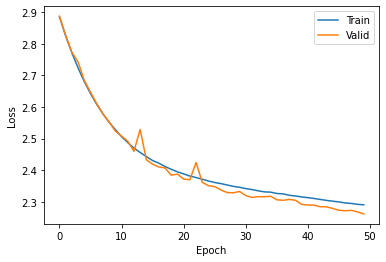

In [21]:
plt.plot(logger["train_loss"])
plt.plot(logger["validation_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

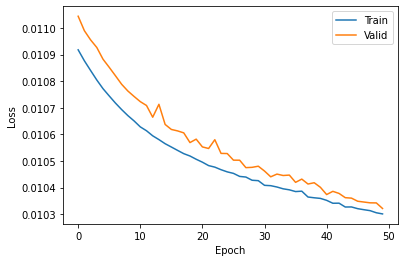

In [22]:
plt.plot(logger["train_gender_loss"])
plt.plot(logger["validation_gender_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

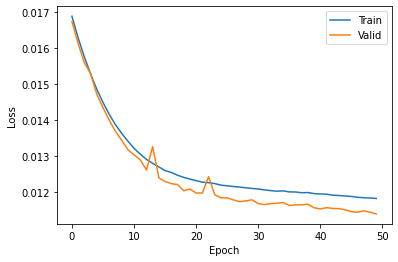

In [23]:
plt.plot(logger["train_mask_loss"])
plt.plot(logger["validation_mask_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

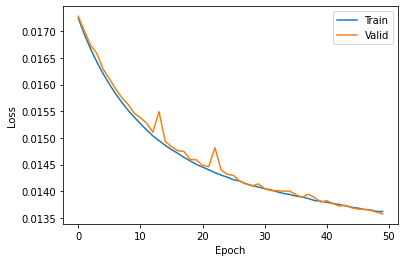

In [24]:
plt.plot(logger["train_age_loss"])
plt.plot(logger["validation_age_loss"])
plt.legend(['Train','Valid'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
torch.save(net, "checkpoint/resnet50_50epochs.pth")

In [26]:
net(torch.Tensor(trainset[0]['image']).unsqueeze(0).to(device))

(tensor([[ 0.4335,  0.4380, -0.7505]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.2784]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.7484, -0.3637, -0.3547]], device='cuda:0', grad_fn=<AddmmBackward>))